In [1]:
from datasets import load_dataset

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import default_collate 

from torchdata.nodes.adapters import IterableWrapper
from torchdata.nodes.batch import Batcher
from torchdata.nodes.map import Mapper
from torchdata.nodes.loader import Loader

import matplotlib.pyplot as plt

### Loading the MNIST dataset

In [2]:
dataset = load_dataset("ylecun/mnist") 
dataset = dataset.with_format("torch")

##### Splitting into train and test

In [3]:
train_dataset = dataset["train"].shuffle(42)

test_dataset = dataset["test"].shuffle(42)

##### Let's display one image

Image size: torch.Size([1, 28, 28])
Label: 8, label size: torch.Size([])


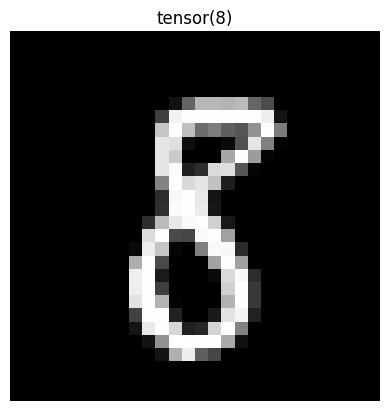

In [4]:

torch.manual_seed(42)
random_idx = torch.randint(0, len(train_dataset), size=[1]).item()
img, label = train_dataset["image"][random_idx], train_dataset["label"][random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(label)
plt.axis("Off");
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

In [5]:
print("length of Train Datasets: ", len(train_dataset))
print("length of Validation Datasets: ", len(test_dataset))

length of Train Datasets:  60000
length of Validation Datasets:  10000


In [6]:
train_dataset["image"][:4]

tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]], dtype=torch.uint8)

### Defining some hyperparameters

In [7]:

torch.manual_seed(0)
num_classes = len(torch.unique(train_dataset["label"]))

# Hyperparameters
batch_size = 128
num_epochs = 10
learning_rate = 0.001



### Now we will use the HF Dataset and create a Batcher object, that will pass us the batches while training and testing

In [8]:
train_node = IterableWrapper(train_dataset)
test_node = IterableWrapper(test_dataset)


#We need a mapper function to convert a dtype and also normalize
def map_fn(item):
    image = item["image"].to(torch.float32)/255
    label = item["label"]

    return {"image":image, "label":label}
    
train_mapper = Mapper(train_node, map_fn)
test_mapper = Mapper(test_node, map_fn)

# We also use the Loader class so that we do not have to manually reset the batcher 
# after every epoch
train_batcher = Loader(Batcher(train_mapper, batch_size, drop_last=True))
test_batcher = Loader(Batcher(test_mapper, batch_size, drop_last=True))



### Defining a simple CNN
###### The NN is just for demonstration. More efficient and accurate archs might exist.

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(10, 20, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        out = self.conv_block1(x)
        out = self.conv_block2(out)
        out = out.view(-1, 320)
        out = self.fc_block(out)
        return out

In [10]:
# Initialize the neural network and loss function
model = Net().to("cpu")
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
model

Net(
  (conv_block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=320, out_features=50, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=50, out_features=10, bias=True)
  )
)

### Train the model

In [12]:

loss_list = []
accuracy_list = []
for epoch in range(num_epochs):
    print(f"epoch = {epoch}")
    num_loops = 0
    total_loss = 0
    for batch in train_batcher:
        batch = default_collate(batch)
        images = batch["image"]
        labels = batch["label"]
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (num_loops+1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{num_loops+1}], Loss: {loss.item():.4f}')
        total_loss+=loss.item()
        num_loops+=1
    total_loss /=num_loops
    loss_list.append(total_loss)
    
    # Test the model
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        for batch in test_batcher:
            batch = default_collate(batch)
            images = batch["image"]
            labels = batch["label"]
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            
            
        acc = 100.0 * n_correct / n_samples
        accuracy_list.append(acc)
        print(f'Test Accuracy: {acc} %')

epoch = 0
Epoch [1/10], Step [50], Loss: 0.8993
Epoch [1/10], Step [100], Loss: 0.4885
Epoch [1/10], Step [150], Loss: 0.2963
Epoch [1/10], Step [200], Loss: 0.3878
Epoch [1/10], Step [250], Loss: 0.1821
Epoch [1/10], Step [300], Loss: 0.2910
Epoch [1/10], Step [350], Loss: 0.1656
Epoch [1/10], Step [400], Loss: 0.0495
Epoch [1/10], Step [450], Loss: 0.1430
Test Accuracy: 95.77323717948718 %
epoch = 1
Epoch [2/10], Step [50], Loss: 0.1356
Epoch [2/10], Step [100], Loss: 0.1093
Epoch [2/10], Step [150], Loss: 0.0818
Epoch [2/10], Step [200], Loss: 0.2703
Epoch [2/10], Step [250], Loss: 0.0982
Epoch [2/10], Step [300], Loss: 0.1945
Epoch [2/10], Step [350], Loss: 0.0585
Epoch [2/10], Step [400], Loss: 0.0276
Epoch [2/10], Step [450], Loss: 0.0770
Test Accuracy: 96.78485576923077 %
epoch = 2
Epoch [3/10], Step [50], Loss: 0.1354
Epoch [3/10], Step [100], Loss: 0.0749
Epoch [3/10], Step [150], Loss: 0.0511
Epoch [3/10], Step [200], Loss: 0.1692
Epoch [3/10], Step [250], Loss: 0.0645
Epoch 

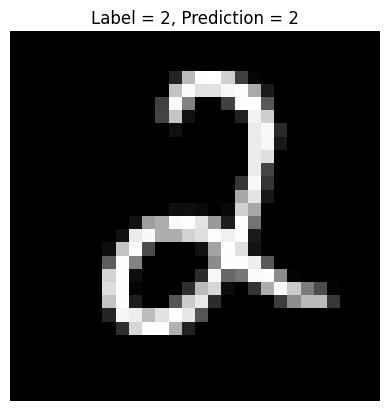

In [13]:

torch.manual_seed(42)
random_idx = torch.randint(0, len(images), size=[1]).item()
img, label , prediction= images[random_idx], labels[random_idx], predicted[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(f"Label = {label}, Prediction = {prediction}")
plt.axis("Off");

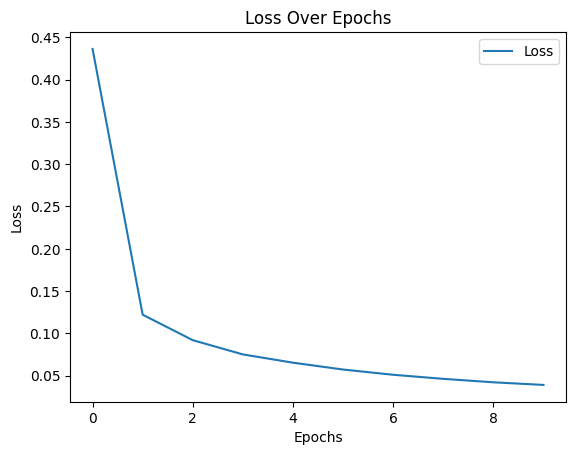

In [14]:
plt.plot(loss_list, label='Loss')


plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Add legend
plt.legend()

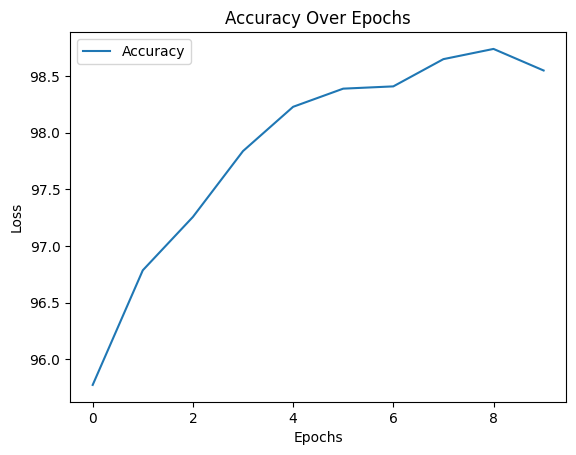

In [15]:
plt.plot(accuracy_list, label='Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Add legend
plt.legend()